In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Performing Basic Visualizations

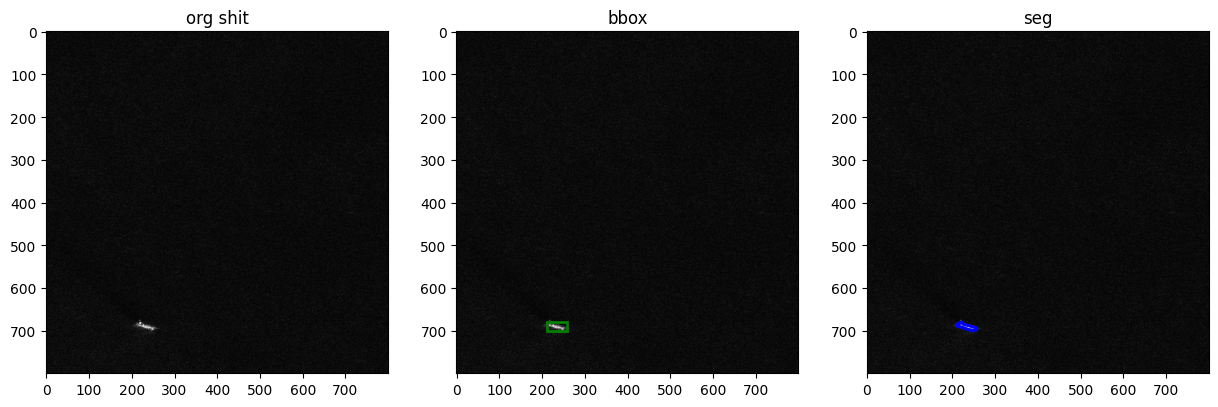

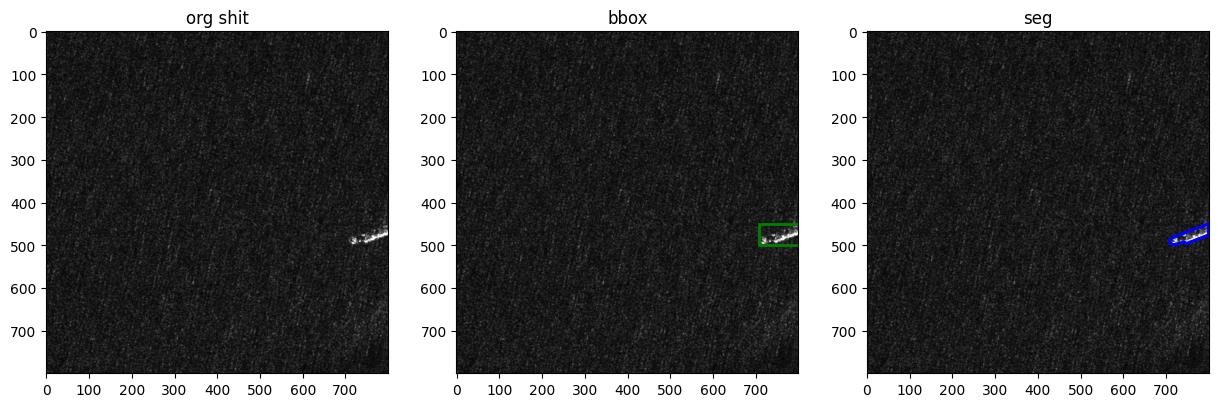

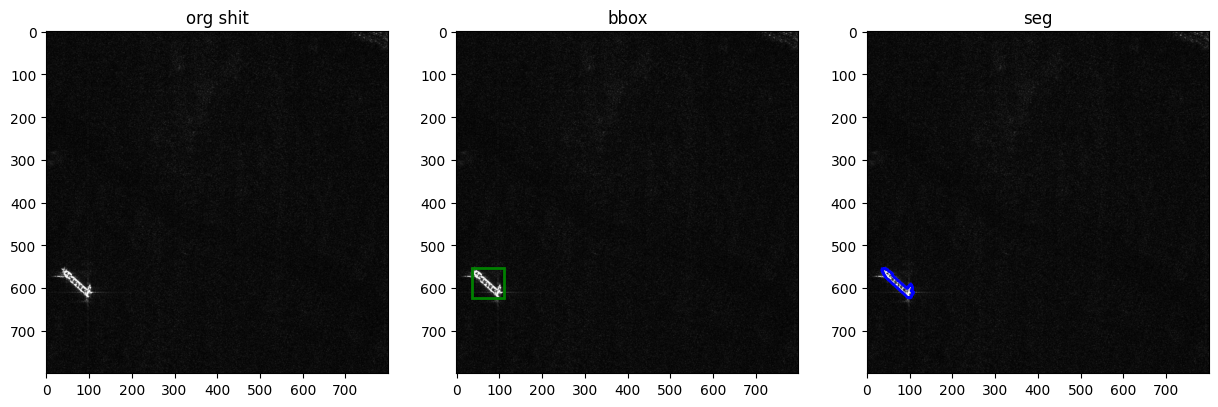

In [15]:
import json
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from matplotlib.path import Path

#function to load annotations -> train2017
def load(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

#function to perform visualizations using images folder and train2017
def visuals(images_folder, annotations, num_imgs=3):
    image_ids = random.sample(range(len(annotations['images'])), num_imgs)
    for image_id in image_ids:
        image_info = annotations['images'][image_id]
        image_path = os.path.join(images_folder, image_info['file_name'])
        image = Image.open(image_path)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        for ax in axes:
            ax.imshow(image)

        for ann in annotations['annotations']:
            if ann['image_id'] == image_info['id']:
                bbox = ann['bbox']
                segmentation = ann['segmentation'][0]

                #drawing the bboxes
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='g', facecolor='none')
                axes[1].add_patch(rect)

                #drawing the segmentations
                vertices = list(zip(segmentation[::2], segmentation[1::2]))
                codes = [Path.MOVETO] + [Path.LINETO] * (len(vertices) - 2) + [Path.CLOSEPOLY]
                path = Path(vertices, codes)
                patch = patches.PathPatch(path, facecolor='none', edgecolor='b', lw=2)
                axes[2].add_patch(patch)

        axes[0].set_title('org shit')
        axes[1].set_title('bbox')
        axes[2].set_title('seg')

        plt.show()


annotations_path = 'annotations/train2017.json'
images_folder = 'Images'

#loading annotations
annotations = load(annotations_path)

#get the visualizations of any 3 imgs
visuals(images_folder, annotations, num_imgs=3)


# PSPNet

In [3]:
import os
import json
import numpy as np
import tensorflow as tf
import cv2
from keras import layers, Model

# Paths to annotations and images folders
annotations_path = 'annotations/train2017.json'
images_folder = 'Images'

# Load annotations
def load_annotations(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

annotations = load_annotations(annotations_path)
print("Annotations loaded.")

# Extract image paths and masks from annotations
image_paths = []
masks = []
for ann in annotations['annotations']:
    image_info = annotations['images'][ann['image_id']]
    image_path = os.path.join(images_folder, image_info['file_name'])
    image_paths.append(image_path)
    mask = np.zeros((800, 800), dtype=np.uint8)
    segmentation = ann['segmentation'][0]
    vertices = list(zip(segmentation[::2], segmentation[1::2]))
    vertices = np.array(vertices, dtype=np.int32)  # Convert vertices to integer format
    cv2.fillPoly(mask, [vertices], 1)
    masks.append(mask)


# Split data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(image_paths, masks, test_size=0.2, random_state=42)
print("Data split into training and validation sets.")

# Define PSPNet model architecture
def build_pspnet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # PSPNet Backbone (e.g., ResNet50)
    backbone = tf.keras.applications.ResNet50(include_top=False, input_tensor=inputs)
    x = backbone.output

    # Pyramid Pooling Module
    pool_sizes = [1, 2, 3, 6]
    pyramid_pooling_outputs = []
    for pool_size in pool_sizes:
        pooled = layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=[1, 2], keepdims=True))(x)
        pooled = layers.Conv2D(512, (1, 1), padding='same', activation='relu')(pooled)
        pooled = layers.UpSampling2D((pool_size, pool_size))(pooled)
        pyramid_pooling_outputs.append(pooled)

    # Apply global average pooling to each output
    global_avg_pooling_outputs = []
    for pooled in pyramid_pooling_outputs:
        global_avg_pooling = layers.GlobalAveragePooling2D()(pooled)
        global_avg_pooling = layers.Reshape((1, 1, 512))(global_avg_pooling)  # Reshape to match channel dimension
        global_avg_pooling_outputs.append(global_avg_pooling)

    # Concatenate the outputs
    x = layers.Concatenate()(global_avg_pooling_outputs)

    # Final Convolutional Layers
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

# Build the model
model = build_pspnet(input_shape=(800, 800, 3))
model.summary()
print("PSPNet model built.")

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Model compiled.")

# Data generator
def data_generator(image_paths, masks, batch_size=32):
    while True:
        indices = np.random.choice(len(image_paths), batch_size)
        batch_images = []
        batch_masks = []
        for idx in indices:
            image = tf.keras.preprocessing.image.load_img(image_paths[idx], target_size=(800, 800))
            image = tf.keras.preprocessing.image.img_to_array(image)
            mask = masks[idx]
            batch_images.append(image)
            batch_masks.append(mask)
        yield np.array(batch_images), np.array(batch_masks)
print("Data generator created.")

# Train the model
batch_size = 2
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

history = model.fit(
    data_generator(X_train, y_train, batch_size),
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=data_generator(X_val, y_val, batch_size),
    validation_steps=validation_steps
)
print("Model trained.")

# Evaluate the model
model.evaluate(data_generator(X_val, y_val, batch_size), steps=validation_steps)
print("Model evaluated.")

Annotations loaded.
Data split into training and validation sets.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 806, 806, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 400, 400, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                            

ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv2_block3_3_bn/FusedBatchNormV3' defined at (most recent call last):
    File "c:\Users\mikip\anaconda3\envs\dl\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\mikip\anaconda3\envs\dl\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue
      await self.process_one()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\kernelbase.py", line 531, in process_one
      await dispatch(*args)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\kernelbase.py", line 775, in execute_request
      reply_content = await reply_content
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\mikip\AppData\Local\Temp\ipykernel_27412\2755078078.py", line 106, in <module>
      history = model.fit(
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model/conv2_block3_3_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[2,256,200,200] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2_block3_3_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_14739]

In [1]:
import os
import json
import numpy as np
import cv2 
import tensorflow as tf
from keras import layers, Model

# Paths to annotations and images folders
annotations_path_train = 'annotations/train2017.json'
annotations_path_test = 'annotations/test2017.json'
images_folder = 'Images'

# Load annotations
def load_annotations(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

annotations_train = load_annotations(annotations_path_train)
annotations_test = load_annotations(annotations_path_test)
print("Annotations loaded.")

# Define data generator
def data_generator(annotations, batch_size=32):
    image_paths = []
    masks = []
    for ann in annotations['annotations']:
        image_info = annotations['images'][ann['image_id']]
        image_path = os.path.join(images_folder, image_info['file_name'])
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(800, 800))
        image = tf.keras.preprocessing.image.img_to_array(image)
        mask = np.zeros((800, 800), dtype=np.uint8)
        segmentation = ann['segmentation'][0]
        vertices = list(zip(segmentation[::2], segmentation[1::2]))
        vertices = np.array(vertices, dtype=np.int32)
        cv2.fillPoly(mask, [vertices], 1)
        image_paths.append(image)
        masks.append(mask)
        if len(image_paths) == batch_size:
            yield np.array(image_paths), np.array(masks)
            image_paths = []
            masks = []
    if image_paths:  # Yield the remaining data if any
        yield np.array(image_paths), np.array(masks)

# Define PSPNet model architecture
def build_pspnet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # PSPNet Backbone (e.g., ResNet50)
    backbone = tf.keras.applications.ResNet50(include_top=False, input_tensor=inputs)
    x = backbone.output

    # Pyramid Pooling Module
    pool_sizes = [1, 2, 3, 6]
    pyramid_pooling_outputs = []
    for pool_size in pool_sizes:
        pooled = layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=[1, 2], keepdims=True))(x)
        pooled = layers.Conv2D(512, (1, 1), padding='same', activation='relu')(pooled)
        pooled = layers.UpSampling2D((pool_size, pool_size))(pooled)
        pyramid_pooling_outputs.append(pooled)

    # Apply global average pooling to each output
    global_avg_pooling_outputs = []
    for pooled in pyramid_pooling_outputs:
        global_avg_pooling = layers.GlobalAveragePooling2D()(pooled)
        global_avg_pooling = layers.Reshape((1, 1, 512))(global_avg_pooling)  # Reshape to match channel dimension
        global_avg_pooling_outputs.append(global_avg_pooling)

    # Concatenate the outputs
    x = layers.Concatenate()(global_avg_pooling_outputs)

    # Final Convolutional Layers
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

# Build the model
model = build_pspnet(input_shape=(800, 800, 3))
model.summary()
print("PSPNet model built.")

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Model compiled.")

# Train the model
batch_size = 32
train_steps = len(annotations_train['annotations']) // batch_size
test_steps = len(annotations_test['annotations']) // batch_size

train_dataset = tf.data.Dataset.from_generator(lambda: data_generator(annotations_train, batch_size),
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 800, 800, 3], [None, 800, 800]))
test_dataset = tf.data.Dataset.from_generator(lambda: data_generator(annotations_test, batch_size),
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=([None, 800, 800, 3], [None, 800, 800]))

history = model.fit(train_dataset, epochs=10, steps_per_epoch=train_steps,
                    validation_data=test_dataset, validation_steps=test_steps)
print("Model trained.")

# Evaluate the model
model.evaluate(test_dataset, steps=test_steps)
print("Model evaluated.")

Annotations loaded.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 806, 806, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 400, 400, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                          

ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv1_conv/Conv2D' defined at (most recent call last):
    File "c:\Users\mikip\anaconda3\envs\dl\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\mikip\anaconda3\envs\dl\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue
      await self.process_one()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\kernelbase.py", line 531, in process_one
      await dispatch(*args)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\kernelbase.py", line 775, in execute_request
      reply_content = await reply_content
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\mikip\AppData\Local\Temp\ipykernel_9952\3659669955.py", line 102, in <module>
      history = model.fit(train_dataset, epochs=10, steps_per_epoch=train_steps,
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'model/conv1_conv/Conv2D'
OOM when allocating tensor with shape[32,400,400,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv1_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_14757]

In [1]:
import os
import json
import numpy as np
import cv2
import tensorflow as tf
from keras import layers, Model

# Paths to annotations and images folders
annotations_path_train = 'annotations/train2017.json'
annotations_path_test = 'annotations/test2017.json'
images_folder = 'Images'

# Load annotations
def load_annotations(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

# Generator function to load data in chunks
def data_generator(annotations, batch_size=32):
    image_paths = []
    masks = []
    for ann in annotations['annotations']:
        image_info = annotations['images'][ann['image_id']]
        image_path = os.path.join(images_folder, image_info['file_name'])
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(800, 800))
        image = tf.keras.preprocessing.image.img_to_array(image)
        mask = np.zeros((800, 800), dtype=np.uint8)
        segmentation = ann['segmentation'][0]
        vertices = list(zip(segmentation[::2], segmentation[1::2]))
        vertices = np.array(vertices, dtype=np.int32)
        cv2.fillPoly(mask, [vertices], 1)
        image_paths.append(image)
        masks.append(mask)
        if len(image_paths) == batch_size:
            yield np.array(image_paths), np.array(masks)
            image_paths = []
            masks = []
    if image_paths:  # Yield the remaining data if any
        yield np.array(image_paths), np.array(masks)

annotations_train = load_annotations(annotations_path_train)
annotations_test = load_annotations(annotations_path_test)
print("Annotations loaded.")

# Define PSPNet model architecture
def build_pspnet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # PSPNet Backbone (e.g., ResNet50)
    backbone = tf.keras.applications.ResNet50(include_top=False, input_tensor=inputs)
    x = backbone.output

    # Pyramid Pooling Module
    pool_sizes = [1, 2, 3, 6]
    pyramid_pooling_outputs = []
    for pool_size in pool_sizes:
        pooled = layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=[1, 2], keepdims=True))(x)
        pooled = layers.Conv2D(512, (1, 1), padding='same', activation='relu')(pooled)
        pooled = layers.UpSampling2D((pool_size, pool_size))(pooled)
        pyramid_pooling_outputs.append(pooled)

    # Apply global average pooling to each output
    global_avg_pooling_outputs = []
    for pooled in pyramid_pooling_outputs:
        global_avg_pooling = layers.GlobalAveragePooling2D()(pooled)
        global_avg_pooling = layers.Reshape((1, 1, 512))(global_avg_pooling)  # Reshape to match channel dimension
        global_avg_pooling_outputs.append(global_avg_pooling)

    # Concatenate the outputs
    x = layers.Concatenate()(global_avg_pooling_outputs)

    # Final Convolutional Layers
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

# Build the model
model = build_pspnet(input_shape=(800, 800, 3))
model.summary()
print("PSPNet model built.")

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Model compiled.")

# Define batch size and steps per epoch
batch_size = 32
train_steps = len(annotations_train['annotations']) // batch_size
test_steps = len(annotations_test['annotations']) // batch_size

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(lambda: data_generator(annotations_train, batch_size),
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 800, 800, 3], [None, 800, 800]))
test_dataset = tf.data.Dataset.from_generator(lambda: data_generator(annotations_test, batch_size),
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=([None, 800, 800, 3], [None, 800, 800]))

# Train the model
history = model.fit(train_dataset, epochs=10, steps_per_epoch=train_steps)
print("Model trained.")

# Evaluate the model
model.evaluate(test_dataset, steps=test_steps)
print("Model evaluated.")


Annotations loaded.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 806, 806, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 400, 400, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                          

ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv1_conv/Conv2D' defined at (most recent call last):
    File "c:\Users\mikip\anaconda3\envs\dl\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\mikip\anaconda3\envs\dl\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue
      await self.process_one()
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\kernelbase.py", line 531, in process_one
      await dispatch(*args)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\kernelbase.py", line 775, in execute_request
      reply_content = await reply_content
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\mikip\AppData\Local\Temp\ipykernel_1244\2148977494.py", line 104, in <module>
      history = model.fit(train_dataset, epochs=10, steps_per_epoch=train_steps)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "c:\Users\mikip\anaconda3\envs\dl\lib\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'model/conv1_conv/Conv2D'
OOM when allocating tensor with shape[32,400,400,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv1_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_14757]

# FPN

In [1]:
import os
import json
import numpy as np
import tensorflow as tf
from keras import layers, Model
import cv2

# Paths to annotations and images folders
train_annotations_path = 'annotations/train2017.json'
test_annotations_path = 'annotations/test2017.json'
images_folder = 'Images'

# Load annotations
def load_annotations(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

train_annotations = load_annotations(train_annotations_path)
test_annotations = load_annotations(test_annotations_path)
print("Annotations loaded.")

# Extract image paths and masks from annotations
def extract_data(annotations):
    image_paths = []
    masks = []
    for ann in annotations['annotations']:
        image_info = annotations['images'][ann['image_id']]
        image_path = os.path.join(images_folder, image_info['file_name'])
        image_paths.append(image_path)
        mask = np.zeros((800, 800), dtype=np.uint8)
        segmentation = ann['segmentation'][0]
        vertices = list(zip(segmentation[::2], segmentation[1::2]))
        vertices = np.array(vertices, dtype=np.int32)  # Convert vertices to integer format
        cv2.fillPoly(mask, [vertices], 1)
        masks.append(mask)
    return image_paths, masks

train_image_paths, train_masks = extract_data(train_annotations)
test_image_paths, test_masks = extract_data(test_annotations)

# Define FPN model architecture
def build_fpn(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Backbone (e.g., ResNet50)
    backbone = tf.keras.applications.ResNet50(include_top=False, input_tensor=inputs)
    c3_output, c4_output, c5_output = [backbone.get_layer(layer_name).output
                                       for layer_name in ['conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']]

    # Top-down pathway
    p5_output = layers.Conv2D(256, (1, 1), padding='same')(c5_output)
    p5_output = layers.UpSampling2D((2, 2))(p5_output)

    p4_output = layers.Conv2D(256, (1, 1), padding='same')(c4_output)
    p4_output = layers.Add()([p5_output, p4_output])
    p4_output = layers.UpSampling2D((2, 2))(p4_output)

    p3_output = layers.Conv2D(256, (1, 1), padding='same')(c3_output)
    p3_output = layers.Add()([p4_output, p3_output])
    p3_output = layers.UpSampling2D((2, 2))(p3_output)

    # Final convolutional layers
    p3_output = layers.Conv2D(256, (3, 3), padding='same')(p3_output)
    p4_output = layers.Conv2D(256, (3, 3), padding='same')(p4_output)
    p5_output = layers.Conv2D(256, (3, 3), padding='same')(p5_output)

    # Output layers
    p3_output = layers.Conv2D(1, (1, 1), activation='sigmoid')(p3_output)
    p4_output = layers.Conv2D(1, (1, 1), activation='sigmoid')(p4_output)
    p5_output = layers.Conv2D(1, (1, 1), activation='sigmoid')(p5_output)

    model = Model(inputs=inputs, outputs=[p3_output, p4_output, p5_output])
    return model

# Build the model
model = build_fpn(input_shape=(800, 800, 3))
model.summary()
print("FPN model built.")

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Model compiled.")

# Define a function to create a dataset from image paths and masks
def create_dataset(image_paths, masks, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, masks))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

# Create training and test datasets
batch_size = 2
train_dataset = create_dataset(train_image_paths, train_masks, batch_size)
test_dataset = create_dataset(test_image_paths, test_masks, batch_size)

# Train the model using the training dataset and validate on the test dataset
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset
)
print("Model trained.")

# Evaluate the model on the test dataset
model.evaluate(test_dataset)
print("Model evaluated.")


Annotations loaded.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 806, 806, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 400, 400, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                          

: 